# Introduction
We recently launched a new line of offict stationery focused on fostering creativity and enhancing brainstorming capabilities. To optimize the sales approach for this new product line, we tested three different sales strategies: email, call, and a combination of email and call. The purpose of this analysis is to evaluate the effectiveness of these sales methods and provide insights to inform the sales strategy moving forward.

This report will detail the data validation and cleaning process, present the results of the explaratory data analysis, define a metric for the business to monitor, and provide recommendations based on the findings. By leveraging data-driven insights, we can hopefully make more informed decisions to improve sales performance and ensure the sucess of the new product line.

In [1]:
# library imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# Data Importing and Validation

The original dataset has 15000 rows and 8 columns.
- The **week** column contains integer values from 1-6 corresponding to each week and 0 null values. No changes to this column were necessary.
- The **sales_method** column contains 5 different unique values **(Email, Call, Email + Call, em + call, email)** and 0 null values. The column should only contain 3 unique values corresponding to each type of sales method. Upon inspection of the values in this column simple mistakes such as different capitalization and use of abbrevations created two extra sets of values. Changes were made and after cleaning the column only contains the following 3 different value types corresponding to each alternate sales method: Email, Call, Email + Call
- The **customer_id** column contains unique identifiers for each customer and had no missing values. No changes to this column were required.
- The **revenue** column had 1074 missing values. I decided that the best approach to handle these missing values would be to replace them by the mean revenue corresponding to each type of sales_method.
- The **years_as_customer** column has 0 missing values, however we had 2 rows with invalid values. Since our company was founded in 1984, the maximum amount of years we could have any given customer is 39. Two rows had values with 47 and 63, which we know is not possible. I assume this was just a mistake in data entry, and I will replace these two values with 39.
- The **nb_site_visits** column has 0 missing values and all data is valid. No changes needed to be made to this column
- The **state** The column has 0 missing values and 50 unique values corresponding to each state. No changes need to be made to this column

Finally after all the data validation and cleaning I checked for any duplicate rows and found none. After cleaning and validating the data our dataset contains 15000 rows and 8 columns with 0 missing values.

In [2]:
# import data
sales_data = pd.read_csv('product_sales.csv')

In [3]:
sales_data.head()

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois


In [4]:
sales_data.shape

(15000, 8)

In [5]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               15000 non-null  int64  
 1   sales_method       15000 non-null  object 
 2   customer_id        15000 non-null  object 
 3   nb_sold            15000 non-null  int64  
 4   revenue            13926 non-null  float64
 5   years_as_customer  15000 non-null  int64  
 6   nb_site_visits     15000 non-null  int64  
 7   state              15000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [6]:
sales_data.describe()

,week,nb_sold,revenue,years_as_customer,nb_site_visits
count,15000.000000,15000.000000,13926.000000,15000.000000,15000.000000
mean,3.098267,10.084667,93.934943,4.965933,24.990867
std,1.656420,1.812213,47.435312,5.044952,3.500914
min,1.000000,7.000000,32.540000,0.000000,12.000000
25%,2.000000,9.000000,52.470000,1.000000,23.000000
50%,3.000000,10.000000,89.500000,3.000000,25.000000
75%,5.000000,11.000000,107.327500,7.000000,27.000000
max,6.000000,16.000000,238.320000,63.000000,41.000000


In [7]:
# Check the value counts to ensure there are only 3 unique values
print(sales_data['sales_method'].value_counts())

Email           7456
Call            4962
Email + Call    2549
em + call         23
email             10
Name: sales_method, dtype: int64


In [8]:
# Define a mapping dictionary to correct the inconsistent values
sales_method_mapping = {
    'Email': 'Email',
    'Call': 'Call',
    'Email + Call': 'Email + Call',
    'em + call': 'Email + Call',
    'email': 'Email'
}

# Apply the mapping to the 'sales_method' column
sales_data['sales_method'] = sales_data['sales_method'].map(sales_method_mapping)

# Check the value counts to ensure there are only 3 unique values
print(sales_data['sales_method'].value_counts())

Email           7466
Call            4962
Email + Call    2572
Name: sales_method, dtype: int64


In [9]:
# find mean revenue for each sales method
mean_revenue_by_sales_method = sales_data.groupby('sales_method')['revenue'].mean()
print(mean_revenue_by_sales_method)

sales_method
Call             47.597467
Email            97.127684
Email + Call    183.651233
Name: revenue, dtype: float64


In [10]:
def replace_null_revenue(row):
    """
    Replaces null (NaN) values in the 'revenue' column of a pandas DataFrame with the mean (or median) revenue
    for the corresponding 'sales_method' group.

    Parameters:
    -----------
    row : pandas Series
        A single row of a pandas DataFrame containing the 'revenue' and 'sales_method' columns.

    Returns:
    --------
    float
        The value of the 'revenue' column for the given row, either the original value if it is not null, or
        the mean (or median) revenue for the corresponding 'sales_method' group if it is null.
    """
    if pd.isnull(row['revenue']):
        return mean_revenue_by_sales_method[row['sales_method']]
    else:
        return row['revenue']

In [11]:
# apply function to the revenue column
sales_data['revenue'] = sales_data.apply(replace_null_revenue, axis=1)

# check for any null values in the revenue column
print(sales_data['revenue'].isnull().sum())

0


In [12]:
sales_data[sales_data['years_as_customer'] > 39]

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
13741,2,Email,18919515-a618-430c-9a05-2c7d8fea96af,10,97.22,63,24,California
13800,4,Call,2ea97d34-571d-4e1b-95be-fea1c404649f,10,50.47,47,27,California


In [13]:
# find all values > 39 and replace with 39
sales_data.loc[sales_data['years_as_customer'] > 39, 'years_as_customer'] = 39

In [14]:
# check to see if replacement worked
sales_data[sales_data['years_as_customer'] > 39]

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state


In [15]:
# check number of unique values for state
sales_data['state'].nunique()

50

In [16]:
# check if any duplicate rows
duplicate_rows = sales_data[sales_data.duplicated()]
duplicate_rows

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state


In [17]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               15000 non-null  int64  
 1   sales_method       15000 non-null  object 
 2   customer_id        15000 non-null  object 
 3   nb_sold            15000 non-null  int64  
 4   revenue            15000 non-null  float64
 5   years_as_customer  15000 non-null  int64  
 6   nb_site_visits     15000 non-null  int64  
 7   state              15000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.6+ KB


# 3. Exploratory Analysis

### A. Number of Customers for each Sales Method
Our most popular sales method during the 6 week period was via Email with a total of 7466 customers, followed by the Call method with 4962 customers and finally the Email + Call method with 2572 total customers.

In [18]:
# find number of customers for each sales method
customers_by_sales_method = sales_data['sales_method'].value_counts()
print(customers_by_sales_method)

Email           7466
Call            4962
Email + Call    2572
Name: sales_method, dtype: int64


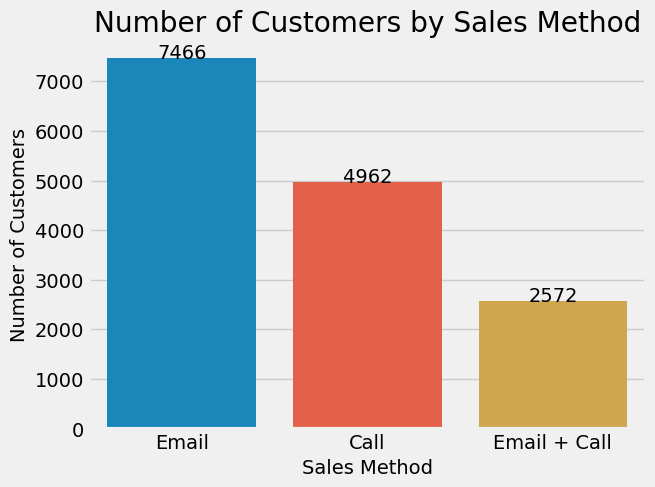

In [19]:
customers_by_sales_method = sales_data['sales_method'].value_counts()

ax = sns.barplot(x=customers_by_sales_method.index, y=customers_by_sales_method.values)

plt.title("Number of Customers by Sales Method")
plt.xlabel("Sales Method")
plt.ylabel("Number of Customers")

# Add value labels to each bar
for i, v in enumerate(customers_by_sales_method.values):
    ax.text(i, v + 0.5, str(v), ha='center')

plt.show()

### B. What is the spread of revenue overall and for each sales method?


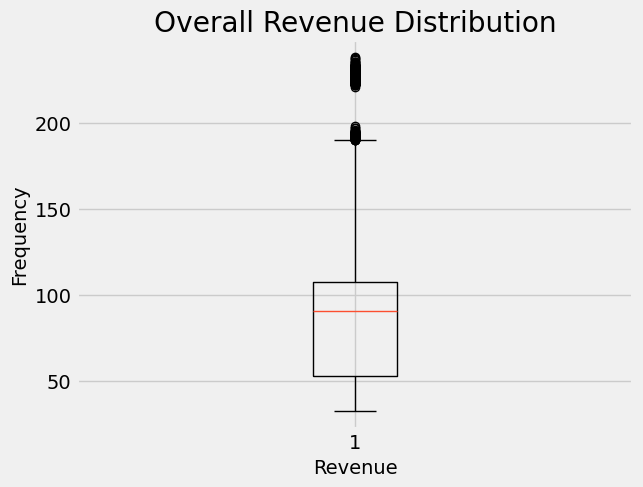

In [20]:
# Histogram for overall revenue
plt.boxplot(sales_data['revenue'])
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.title('Overall Revenue Distribution')
plt.show()

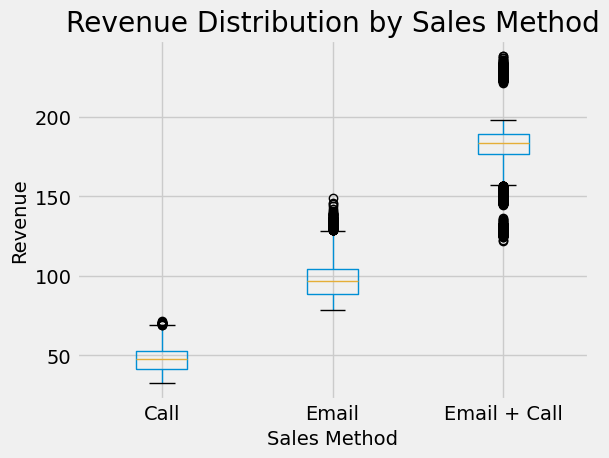

In [21]:
sales_data.boxplot(column='revenue', by='sales_method')
plt.xlabel('Sales Method')
plt.ylabel('Revenue')
plt.title('Revenue Distribution by Sales Method')
plt.suptitle('')  # Remove auto-generated sup-title
plt.show()

### C. Revenue over Time For Each Sales Method

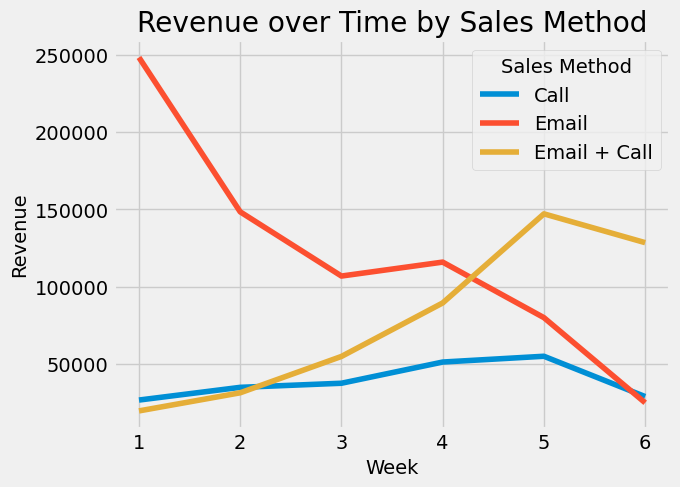

In [22]:
revenue_over_time = sales_data.groupby(['week', 'sales_method'])['revenue'].sum().unstack()
revenue_over_time.plot()
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.title('Revenue over Time by Sales Method')
plt.legend(title='Sales Method')
plt.show()

From the table above we see following:
- In week 1, the 'Email' sales method generated the highest revenue ($48,122.68), followed by 'Email + Call' (20,007.40) and 'Call' (27,015.93). However, it is important to note that the 'Email' method required the least effort from the sales team, making it the most efficient method during the first week.
- Over the course of the 6 weeks sales generated from the Email sales method consistently decreased. This decline in revenue overtime could indicate diminishing returns from the Email sales method as time goes on.
- The call method shows an overall incresing trend in revenue overtime with some fluctations. Towards the end of the 6 week period the amount of revenue generated from the Call method began to decrease.
- The Email + Call method shows a healthy increasing trend of revenue over the 6 week period. It's possible that this method would be the most beneficial in terms of long-term revenue growth compared to the two other sales methods.

In conclusion, the Email + Call sales method appears to be the most promising in terms of long-term revenue generation, although it does require more effort from the sales team. The Email method starts strong but shows a steady decline, while the Call method has an overall increasing trend but fluctuates more. It is recommended to consider the efficiency and effort required for each method while making a decision on which sales method to continue using.

In [23]:
revenue_over_time

sales_method,Call,Email,Email + Call
week,,,
1,27015.934407,248122.682313,20007.400954
2,35219.944012,148478.487577,31702.115744
3,37865.583880,107047.993157,55164.933140
4,51545.486149,116044.223157,89682.576419
5,55279.216281,80201.111052,147195.006815
6,29252.466808,25260.792947,128598.937094


### D. Investigating other differences between customers in each group
Looking at the charts below we can make some interesting observations:
- The number of years we've done business with customers across each sales method was more or less equal.
- The email + call sales method saw an average of 12 sales per customer compared to 10 for call and email methods. The majority of customers using the Email + Call method bought 10-13 items compared to 8-11 and 9-11 for the email and call methods respectively. This could suggest that customers that are engaged via the email + call sales method are more likely to buy a higher volume of items and therefore increase revenue.
- We can also see that customer's that were contacted via the email + call sales method had more site visits on average than the email and call methods individually. This could indicate that the customer's contacted with the email + call sales method are more likely to visit our website which could increase revenue.

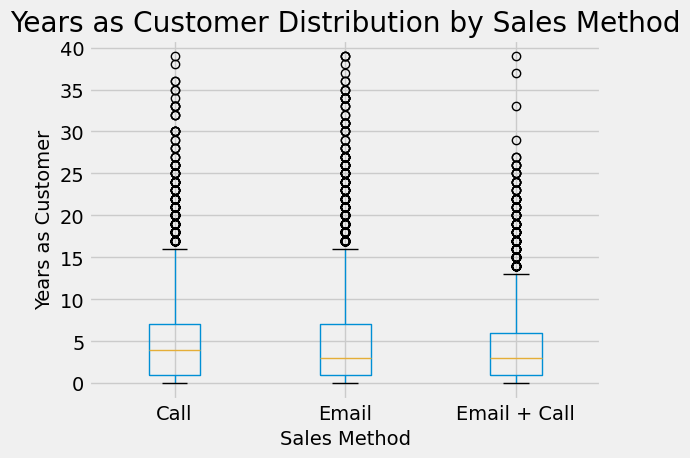

In [24]:
# Example: Boxplot for years_as_customer by sales_method
sales_data.boxplot(column='years_as_customer', by='sales_method')
plt.xlabel('Sales Method')
plt.ylabel('Years as Customer')
plt.title('Years as Customer Distribution by Sales Method')
plt.suptitle('')  # Remove auto-generated sup-title
plt.show()

# Other comparisons can be performed similarly (e.g., nb_site_visits, state, etc.)

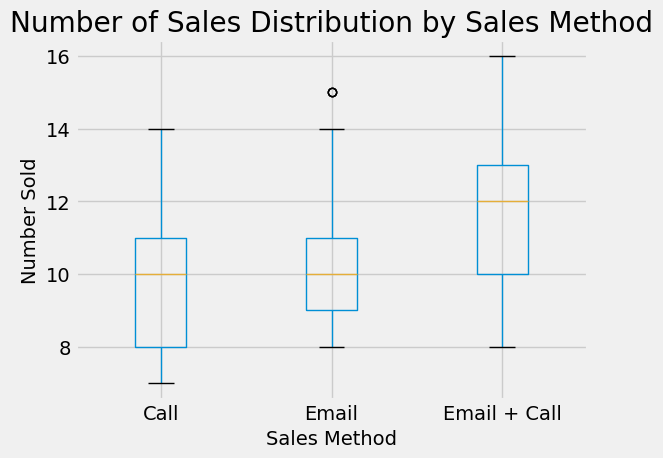

In [25]:
# Example: Boxplot for years_as_customer by sales_method
sales_data.boxplot(column='nb_sold', by='sales_method')
plt.xlabel('Sales Method')
plt.ylabel('Number Sold')
plt.title('Number of Sales Distribution by Sales Method')
plt.suptitle('')  # Remove auto-generated sup-title
plt.show()

# Other comparisons can be performed similarly (e.g., nb_site_visits, state, etc.)

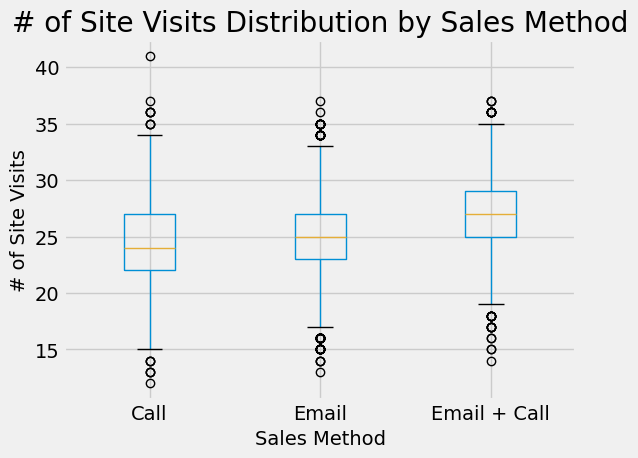

In [26]:
# Example: Boxplot for years_as_customer by sales_method
sales_data.boxplot(column='nb_site_visits', by='sales_method')
plt.xlabel('Sales Method')
plt.ylabel('# of Site Visits')
plt.title('# of Site Visits Distribution by Sales Method')
plt.suptitle('')  # Remove auto-generated sup-title
plt.show()

# Other comparisons can be performed similarly (e.g., nb_site_visits, state, etc.)

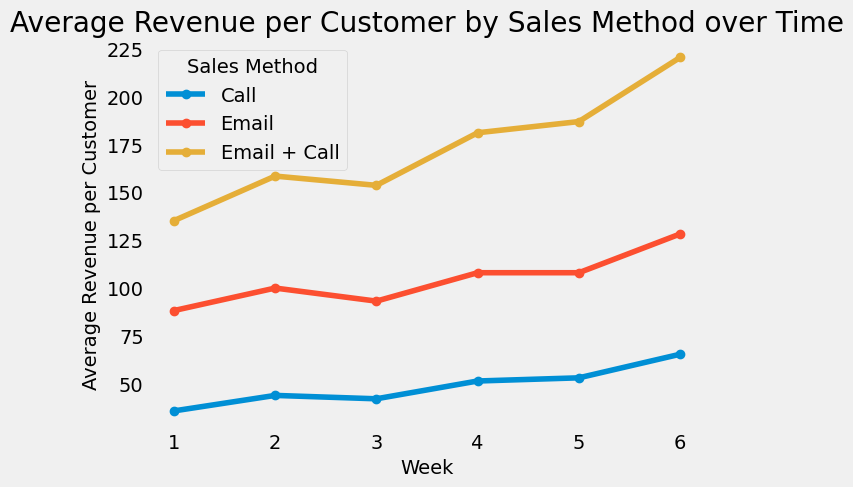

In [27]:
grouped_data = sales_data.groupby(['week', 'sales_method']).agg({'revenue': 'sum', 'customer_id': 'count'}).reset_index()
grouped_data['average_revenue_per_customer'] = grouped_data['revenue'] / grouped_data['customer_id']
pivot_data = grouped_data.pivot_table(index='week', columns='sales_method', values='average_revenue_per_customer')
pivot_data.plot(kind='line', marker='o')
plt.xlabel('Week')
plt.ylabel('Average Revenue per Customer')
plt.title('Average Revenue per Customer by Sales Method over Time')
plt.legend(title='Sales Method')
plt.grid()
plt.show()

## 4. Defining Business Metrics to Track Performance - Average Revenue per Customer Sales Effort
To get a better understanding of the performance of each sales method I create a metric called Average Reveue per Customer Sales Effort(ARPSE). This metric takes into account the difficulty of each sales method in terms of time spent with email having a value of 0.5, email + call 1 and call 3.

**ARCPM = (Total Revenue for Method) / (Number of customers * Sales effort)**

In [28]:
# Define the sales effort for each sales method
sales_effort = {
    'Email': 0.5,
    'Call': 3,
    'Email + Call': 1
}

# Group the data by sales_method and aggregate the total revenue and number of customers
grouped_data = sales_data.groupby('sales_method').agg({'revenue': 'sum', 'customer_id': 'count'}).reset_index()

# Calculate ARCPSE for each sales method
grouped_data['ARCPSE'] = grouped_data.apply(lambda row: row['revenue'] / (row['customer_id'] * sales_effort[row['sales_method']]), axis=1)

# Display the ARCPSE for each sales method
print(grouped_data[['sales_method', 'ARCPSE']])


   sales_method      ARCPSE
0          Call   15.865822
1         Email  194.255368
2  Email + Call  183.651233


The ARCPSE results show that Email has the highest value with 194.25, followed by Email + Call with 183.65 and finally call with 15.86. This suggests that the call method is the most efficient in terms of reveneue generated per unit of effort.

However, it is important to note that additional factors have been observed. The 'Email + Call' method had customers with more website visits and higher average number of items purchased. Moreover, this method demonstrated a steady increase in revenue growth over the six-week period. In contrast, the 'Call' method showed high revenue in week 1 but decreased over time.

## Conclusion and Recommendations
Taking in all factors from the analysis it is recommended to focus on the Email + Call method for the following reasons:

- While 'Email' has the highest ARCPSE, the 'Email + Call' method generates more customer engagement, as evidenced by higher website visits and average items purchased. This could lead to stronger customer relationships and long-term growth.
- The 'Email + Call' method has shown a consistent upward trend in revenue generation over six weeks, indicating its potential for continued success.
- The 'Call' method is the least efficient in terms of effort and revenue generation and has a downward trend in revenue over time.
In conclusion, the 'Email + Call' method should be prioritized for sales efforts, as it demonstrates better customer engagement, consistent revenue growth, and a more sustainable balance between effort and return.